In [319]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib inline

In [437]:
# Q-Table size in each dimension
# Strangly for numbers >= 100 we do never reach more than 100 steps on average
number_of_bins_per_dimension = 10

# Max and min intervals 
# From docs and plotting (guessed edges)
dimension_1_low = -2.4
dimension_1_high = 2.4

dimension_2_low = -2
dimension_2_high = 2

dimension_3_low = -1
dimension_3_high = 1

dimension_4_low = -3.5
dimension_4_high = 3.5

# Push all of that into one array
borders = np.array([
        [dimension_1_low, dimension_1_high],
        [dimension_2_low, dimension_2_high],
        [dimension_3_low, dimension_3_high],
        [dimension_4_low, dimension_4_high]
       ], dtype=np.float64)

In [438]:
def map_observation_to_bins(observation, borders, max_bins):
    """
    Will map each observation into it's bins
    having bin 0 < min and bin max_bins - 1 for > max
    """
    bins = []
    for i, single_observation in enumerate(observation):
        low, high = borders[i]
        if single_observation > high:
            bins.append(max_bins - 1)
        elif single_observation < low:
            bins.append(0)
        else:
            #@Todo precalc that into the borders array to speed up
            spread = np.float64(high - low)
            bin_width = np.float64(spread / (max_bins - 3))
            
            # maybe store that into some lookup table? 
            bins.append(int((single_observation + abs(low)) / bin_width + 1))
    return bins
        

In [439]:
# Test
map_observation_to_bins([0,-100,-9.9, 11], borders, number_of_bins_per_dimension)

[4, 0, 0, 9]

In [440]:
def build_Q_table(action_count, states, bins_per_state):
    """
    Will create a bins^state*action_acount Matrix
    """
    shape = []
    for i in range(states):
        shape.append(bins_per_state)
    shape.append(action_count)
    return np.zeros(shape=shape, dtype=np.float64)

In [441]:
Q_table = build_Q_table(action_count=2, states=len(borders), bins_per_state=number_of_bins_per_dimension)

In [442]:
Q_table.shape

(10L, 10L, 10L, 10L, 2L)

In [443]:
Q_table.nbytes / 1024 / 1024

0

In [444]:
def get_action_values_for_bin(bins, n_actions, q_matrix):
    """
    Returns all action-values given a matrix position
    """
    values = []
    idx_base = map(lambda x: [x], bins)
    for i in range(n_actions):
            idx = idx_base + [i]
            values.append(q_matrix[idx][0])
    return values, idx_base
                
def do_q_learning(env, q_matrix, observation_to_bin_mapper, alpha=0.8, gamma=0.8, episodes=199, epsilon=0.05, **mapper_args):
    """
    Plays an episode until done or "episodes" steps are made
    alpha and gamma are learning rates (big alpha = focus more on reward, big gamma = take next step more into account)
    observation bin mapper is a function which transforms an observation from env into an index for q_matrix in form of 
    [[dim_1],[dim_2],...,[dim_max_obersvation]]
    mapper_args will be passed to the observation mapper as-is
    """
    observation = env.reset()
    bins = observation_to_bin_mapper(observation=observation, **mapper_args)
    done = False
    steps_survived = 0
    
    while not done:
        # look into all possible moves
        vals, idx = get_action_values_for_bin(bins=bins,
                                         n_actions=env.action_space.n, 
                                         q_matrix=q_matrix)
        
        # greedy pick move with highest value (or random)
        if np.random.random() < epsilon:
            move = env.action_space.sample()
        else:
            move = np.argmax(vals)
            #max_val = np.max(vals)
            #possible_moves_mask = vals == max_val # if two moves have same reward, we choose randomly
            #possible_moves = np.argwhere(possible_moves_mask == True).flatten()
            #move = np.random.choice(possible_moves)
        # print vals, move
        # move = np.random.choice([0,1])
        
        idx += [move]
    
        # Move one step
        observation, reward, done, _ = env.step(move)

        # Calculate new position
        bins = observation_to_bin_mapper(observation=observation, **mapper_args)

        # Get best action values for next step
        vals, _ = get_action_values_for_bin(bins=bins, 
                                                  n_actions=env.action_space.n, 
                                                  q_matrix=q_matrix)
        if done == True:
            if steps_survived < episodes:
                reward = -300
        else:
            reward = 1
            
        steps_survived += 1
        
        # Update q-matrix
        q_matrix[idx] = (1 - alpha) * q_matrix[idx] + alpha * (reward + gamma * (np.max(vals)))
            
    return q_matrix, steps_survived

In [445]:
env = gym.make("CartPole-v0")

Round until 100 survived average 22 steps (Max: 79)
Round until 200 survived average 41 steps (Max: 114)
Round until 300 survived average 45 steps (Max: 131)
Round until 400 survived average 61 steps (Max: 200)
Round until 500 survived average 65 steps (Max: 200)
Round until 600 survived average 74 steps (Max: 200)
Round until 700 survived average 64 steps (Max: 200)
Round until 800 survived average 52 steps (Max: 200)
Round until 900 survived average 44 steps (Max: 110)
Round until 1000 survived average 68 steps (Max: 143)
Round until 1100 survived average 65 steps (Max: 173)
Round until 1200 survived average 71 steps (Max: 173)
Round until 1300 survived average 61 steps (Max: 200)
Round until 1400 survived average 76 steps (Max: 200)
Round until 1500 survived average 66 steps (Max: 170)
Round until 1600 survived average 85 steps (Max: 200)
Round until 1700 survived average 64 steps (Max: 200)
Round until 1800 survived average 87 steps (Max: 200)
Round until 1900 survived average 51 s

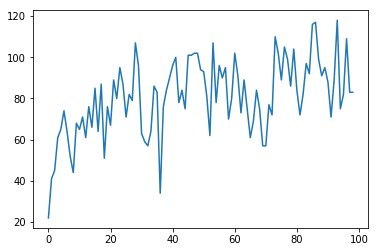

In [447]:
play_mat = np.copy(Q_table)
step_sum = 0
steps = 1
max_round = 0
average_hist = []

for i in range(10000):
    play_mat, steps = do_q_learning(env=env, 
              q_matrix=play_mat, 
              observation_to_bin_mapper=map_observation_to_bins, 
              borders=borders, 
              max_bins=number_of_bins_per_dimension, 
              epsilon=1.0/sqrt(i+1) # the worse the result, the more we take random steps (Seems legit ...)
           )
    # also we want to see the best run for that round
    if steps > max_round:
        max_round = steps
    step_sum += steps
    
    if i > 0 and i % 100 == 0:
        print "Round until {} survived average {} steps (Max: {})".format(i, step_sum / 100, max_round)
        average_hist.append(step_sum / 100)
        step_sum = 0
        max_round = 0
        
print "Playing last round without randomness"
_, steps = do_q_learning(env=env, 
      q_matrix=play_mat, 
      observation_to_bin_mapper=map_observation_to_bins, 
      borders=borders, 
      max_bins=number_of_bins_per_dimension, 
      epsilon=-1 # the worse the result, the more we take random steps (Seems legit ...)
   )
print "Steps: {}".format(steps)

plt.plot(average_hist)